In [1]:
#import pandas
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

# 1. DATA

## 1.1. Read Data

In [9]:
#get data
time_serie = pd.read_csv('./data/1979_200kmSantiago.csv')
time_serie['time'] = pd.to_datetime(time_serie['time']) #.astype('datetime64[ns]')
time_serie['date'] = pd.to_datetime([d.date() for d in time_serie['time']])
time_serie['hour'] = [d.time() for d in time_serie['time']]

#view top 3 records
time_serie.head(3)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,date,hour
0,2019-05-27 15:25:24.989000+00:00,-33.0339,-72.0603,16.84,4.4,mwr,NaN,137.0,0.355,0.69,...,earthquake,4.2,1.7,0.037,69.0,reviewed,us,us,2019-05-27,15:25:24.989000
1,2019-05-23 00:59:25.420000+00:00,-34.7971,-71.8098,48.09,4.1,mwr,NaN,83.0,0.722,0.56,...,earthquake,2.4,9.8,0.043,51.0,reviewed,us,us,2019-05-23,00:59:25.420000
2,2019-05-18 02:52:25.970000+00:00,-33.3110,-70.3431,98.23,4.2,mwr,NaN,77.0,0.045,0.31,...,earthquake,5.0,4.3,NaN,NaN,reviewed,us,guc,2019-05-18,02:52:25.970000


In [11]:
time_serie.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'date', 'hour'],
      dtype='object')

## 1.2. Select columns

The Richter magnitude scale can only be used when seismographs are within 600 km of the earthquake. For greater distances, other magnitude scales have been defined. While not exactly the same as the original Richter magnitude, they give values that can range from less than 0.0 to over 9.0. For example, the surface wave magnitude, MS, is often used for large distant earthquakes. Most of these scales saturate at some magnitude and do not properly represent earthquake size for larger events. For example, the ML scale saturates over ML 6.0, while the MS scale can be used to about MS 8.0.

The most modern scale is the moment magnitude scale MW, which can be used for a wide range of magnitudes and distances. This has been defined so that the numerical value is close to ML for earthquakes up to magnitude 6.0, and close to MS for magnitudes 6.0 to 8.0. The very largest earthquakes, such as experienced in Chile in 1960 or Alaska in 1964, can reach magnitudes larger than MW 9.0.

So, for this exercise we don't take into account 'magType' and we assume all magnitude to be the same type.

In [12]:
ts = time_serie[['id', 'date', 'latitude', 'longitude', 'depth', 'mag', 'place','time']].sort_values(by=['date'])

In [13]:
ts.head()

,id,date,latitude,longitude,depth,mag,place,time
18521,usp0000z70,1979-03-07,-32.699,-71.942,29.0,4.9,"offshore Valparaiso, Chile",1979-03-07 22:57:09.600000+00:00
18520,usp0000zk2,1979-03-22,-31.796,-69.867,117.0,4.7,"San Juan, Argentina",1979-03-22 06:51:10.600000+00:00
18519,usp0000zv5,1979-04-06,-33.148,-72.401,33.0,4.1,"offshore Valparaiso, Chile",1979-04-06 11:29:08.800000+00:00
18518,usp000109s,1979-04-26,-33.821,-71.901,38.0,5.8,"offshore Valparaiso, Chile",1979-04-26 02:00:09.600000+00:00
18516,usp00011r2,1979-07-06,-32.484,-71.584,44.0,4.8,"offshore Valparaiso, Chile",1979-07-06 11:36:32.800000+00:00


In [14]:
ts.describe()

,latitude,longitude,depth,mag
count,18522.000000,18522.000000,18522.000000,18522.000000
mean,-33.245880,-71.081183,51.188379,3.505518
std,0.882855,0.836668,41.817346,0.653193
min,-35.231000,-72.793000,0.000000,2.500000
25%,-33.951000,-71.783000,14.900000,3.000000
50%,-33.144000,-71.173000,35.000000,3.500000
75%,-32.524250,-70.352000,88.800000,3.900000
max,-31.639000,-68.504000,226.100000,8.000000


## 1.3. Check null values

In [15]:
ts.isnull().sum(axis = 0)

id           0
date         0
latitude     0
longitude    0
depth        0
mag          0
place        0
time         0
dtype: int64

In [16]:
ts.isnull().values.any()

False

## 1.4. Duplicates

There is no duplicates by id

In [17]:
ts[ts['id'].duplicated()]

,id,date,latitude,longitude,depth,mag,place,time


In [18]:
ts[ts[['date', 'latitude', 'longitude']].duplicated()]

,id,date,latitude,longitude,depth,mag,place,time
11974,usp00094cx,1999-03-12,-33.158,-70.271,5.8,3.4,"Region Metropolitana, Chile",1999-03-12 16:28:22+00:00
7456,usp000bstj,2003-03-16,-33.616,-70.595,25.2,2.9,"Region Metropolitana, Chile",2003-03-16 17:28:18+00:00


In [19]:
ts.loc[[11974,11975,11976,11972,11973]]

,id,date,latitude,longitude,depth,mag,place,time
11974,usp00094cx,1999-03-12,-33.158,-70.271,5.8,3.4,"Region Metropolitana, Chile",1999-03-12 16:28:22+00:00
11975,usp00094bv,1999-03-12,-33.158,-70.271,111.8,2.6,"Region Metropolitana, Chile",1999-03-12 05:50:04.590000+00:00
11976,usp00094bk,1999-03-12,-33.397,-70.041,127.8,2.9,"Region Metropolitana, Chile",1999-03-12 02:55:58.760000+00:00
11972,usp00094dy,1999-03-13,-33.413,-70.212,9.4,3.1,"Region Metropolitana, Chile",1999-03-13 02:55:28.320000+00:00
11973,usp00094dw,1999-03-13,-33.664,-71.410,44.8,3.7,"Valparaiso, Chile",1999-03-13 02:32:01.230000+00:00


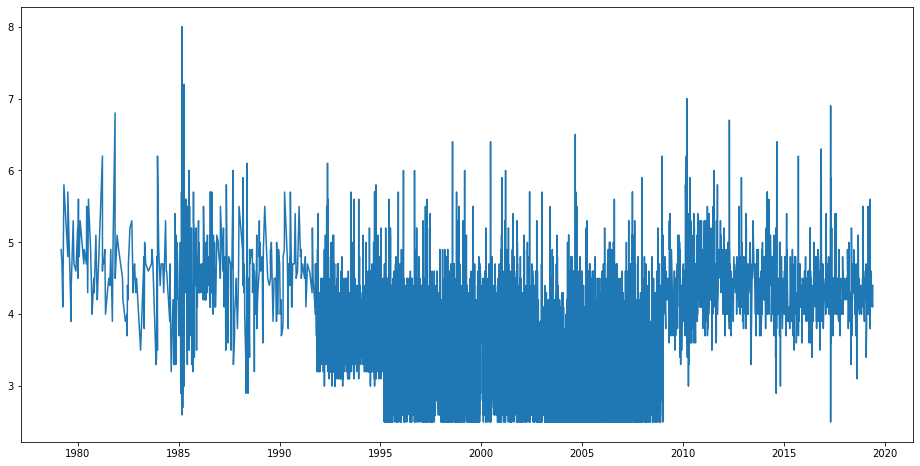

In [20]:
plt.figure(figsize=(16, 8))
plt.plot(ts['date'],ts['mag'])
plt.show();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d1e8278>,
      dtype=object)

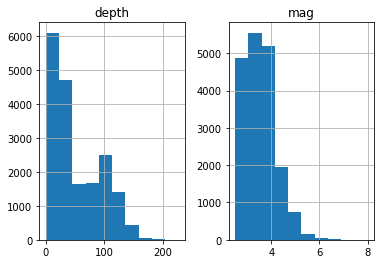

In [21]:
ts.hist(['depth','mag'])

## 1.5 New features

In [82]:
ts['year'] = pd.DatetimeIndex(ts['date']).year
ts['month'] = pd.DatetimeIndex(ts['date']).month

ts['YM'] =  pd.to_datetime(ts['year'].astype(str) + '-' + ts['month'].astype(str))
#ts['YM'] = ts['YM'].apply(lambda x : '{0:%Y-%m}'.format(x))

In [23]:
custom_magnitudes = ([0. , 4. , 6 , 10. ])
ts['magtype'] = pd.cut(ts['mag'], custom_magnitudes, labels=["low", "medium", "high"])

In [24]:
ts.head(2)

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype
18521,usp0000z70,1979-03-07,-32.699,-71.942,29.0,4.9,"offshore Valparaiso, Chile",1979-03-07 22:57:09.600000+00:00,1979,3,1979-03,medium
18520,usp0000zk2,1979-03-22,-31.796,-69.867,117.0,4.7,"San Juan, Argentina",1979-03-22 06:51:10.600000+00:00,1979,3,1979-03,medium


In [83]:
ts.dtypes

id                        object
date              datetime64[ns]
latitude                 float64
longitude                float64
depth                    float64
mag                      float64
place                     object
time         datetime64[ns, UTC]
year                       int64
month                      int64
YM                datetime64[ns]
magtype                 category
dtype: object

# 2. ANALYSIS

## 2.1. frequency per year 

In [26]:
frequency_year = (ts[['year','magtype','mag']]
                    .groupby(['year', 'magtype']) 
                    .agg(['count','max'])
                    .unstack(fill_value=0).stack()
                    .reset_index()
                    .sort_index() 
)
frequency_year.columns = [''.join(x) for x in frequency_year.columns.ravel()]

In [27]:
frequency_year.head(6)

,year,magtype,magcount,magmax
0,1979,low,1,3.9
1,1979,medium,11,5.8
2,1979,high,0,0.0
3,1980,low,1,4.0
4,1980,medium,20,5.6
5,1980,high,0,0.0


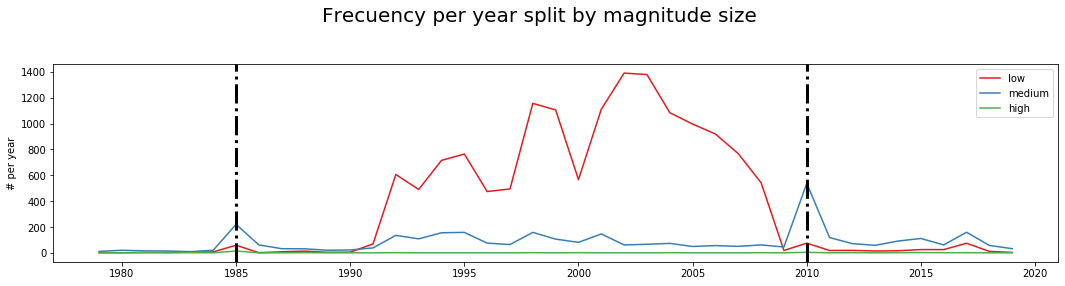

In [34]:
# Values X axis
years = frequency_year['year'].unique()

# Create a color palette
palette = plt.get_cmap('Set1')

# Set plot figure size
plt.figure(figsize=(18,8))
plt.subplot(211)
plt.ylabel('# per year')
plt.suptitle('Frecuency per year split by magnitude size', fontsize=20)
for i, magtype in enumerate(frequency_year['magtype'].unique()):
    # Values Y axis
    magmax_type_year = np.array(frequency_year[frequency_year['magtype']==magtype]['magcount'])
    # One line per magnitude type
    plt.plot(years, magmax_type_year, color=palette(i), label=magtype)
    
# one bar per greatest earthquakes
years_great = ts[ts['mag']>=7]['year'].unique()

for year in years_great:
    plt.axvline(x=year, color ="black", ls='-.', lw=3 )

plt.legend(loc = 'best')

plt.show;

In [ ]:
ts.groupby(['YM']).max()

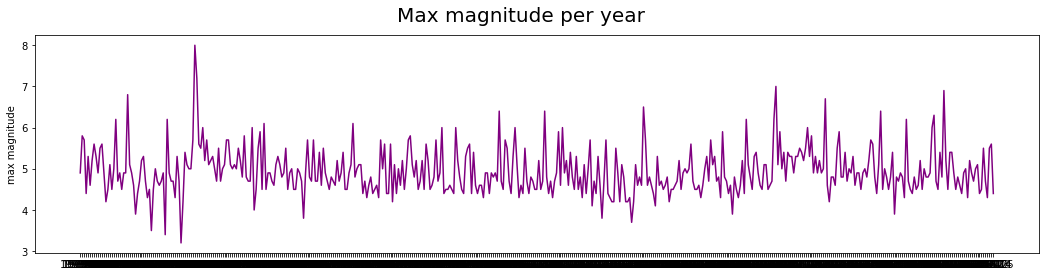

In [35]:
fig = plt.figure(figsize=(18,4)) 
ax = fig.add_subplot(111) 
ax.plot(ts.groupby(['YM']).max()['mag'], color='purple', label=magtype)
plt.suptitle('Max magnitude per month/year', fontsize=20)
ax.set(ylabel='max magnitude')

plt.show;

# 2.2 Time Series

In [155]:
dfTiSe = (ts[['YM','mag']]
          .groupby(['YM']).max()
          .sort_index())

In [188]:
allmonths = pd.DataFrame()
allmonths['YM'] = pd.date_range(start='1/1/1979', end='6/1/2019', freq='MS')

In [177]:
full_time_series = (allmonths.merge(dfTiSe, left_on='YM', right_index=True, how='left')
                   .fillna(ts['mag'].mean())
                   .set_index(allmonths['YM'])
                   .sort_index())

del full_time_series["YM"]
full_time_series.head(2)

,mag
YM,
1979-01-01,3.505518
1979-02-01,3.505518


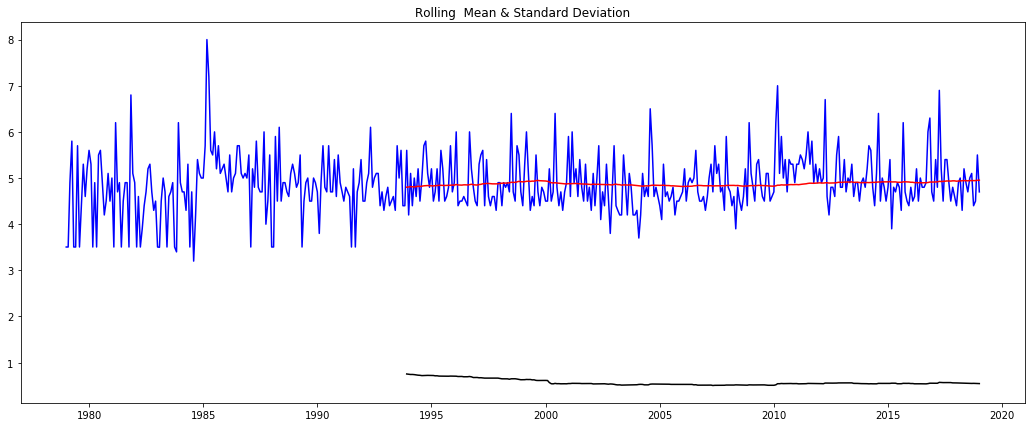

In [193]:
#Determining rolling statistics
window_size = 180
rolmean = full_time_series.rolling(window = window_size).mean()
rolstd = full_time_series.rolling(window = window_size).std()

#plotting rolling statistics
plt.figure(figsize=(18,7))
plt.title('Rolling  Mean & Standard Deviation')
orig = plt.plot(full_time_series, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
plt.show()

In [196]:
#Dickey_Fuller test:
print('''Results of Dickey-Fuller Test: 
    Null Hypothesis: TS has a unit root and hence is non-stationary.
    Test Statistic: The more negative, the more likely we are to reject the null hypothesis (we have a stationary dataset).
    (p-value): is small, we can reject the null hypothesis and say that the series is stationary.\n''')
dftest = adfuller(full_time_series['mag'])
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 
    Null Hypothesis: TS has a unit root and hence is non-stationary.
    Test Statistic: The more negative, the more likely we are to reject the null hypothesis (we have a stationary dataset).
    (p-value): is small, we can reject the null hypothesis and say that the series is stationary.

Test Statistic                -8.343382e+00
p-value                        3.132207e-13
#Lags Used                     3.000000e+00
Number of Observations Used    4.770000e+02
Critical Value (1%)           -3.444134e+00
Critical Value (5%)           -2.867618e+00
Critical Value (10%)          -2.570008e+00
dtype: float64


In [197]:
def log_positivo(x):
    if x>0: 
        return np.log(x) 
    else: 
        return 0
ts_log = full_time_series.applymap(log_positivo)
ts_log.head()

,mag
YM,
1979-01-01,1.254338
1979-02-01,1.254338
1979-03-01,1.589235
1979-04-01,1.757858
1979-05-01,1.254338


In [200]:
decomposition = seasonal_decompose(full_time_series)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

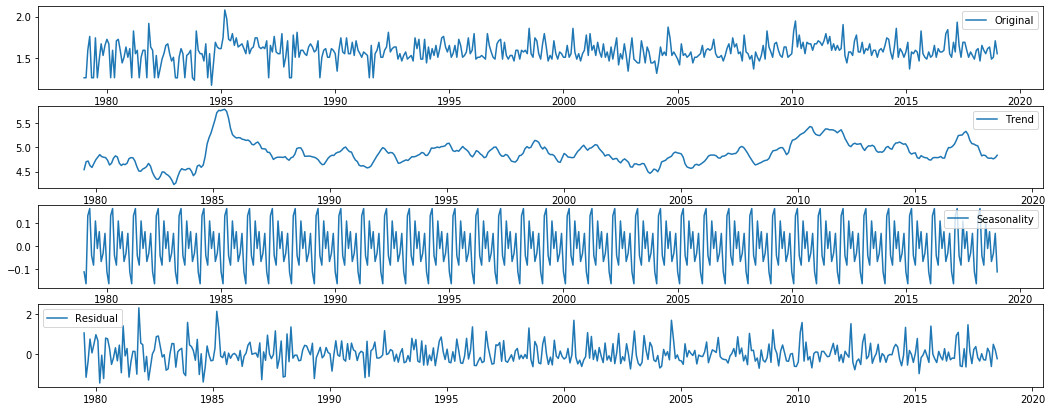

In [201]:
plt.figure(figsize=(18,7))
plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')
plt.show;

In [ ]:
#Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction